# KOMO: Motion Optimization

KOMO is a framework for designing motion by formulating optimization problems. Inverse kinematics (IK) is the special case of optimizing only over a single configuration rather than a path. Formulating KOMO problems is key to realizing motion in `rai`.

This tutorial shows basics on how IK, rough waypoint optimization, and fine path optimization can be formulated as non-linear mathematical program (NLP) using KOMO. Essentially, the `addObjective` allows to add costs or constraints over any `Feature` to the NLP (same features that can be evaluated with 'C.eval').

## Minimal IK example

In [1]:
from robotic import ry
import numpy as np
import time

In [2]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.view()

0

In [3]:
C.addFrame('box') \
    .setPosition([-.25,.1,1.]) \
    .setShape(ry.ST.ssBox, size=[.06,.06,.06,.005]) \
    .setColor([1,.5,0]) \
    .setContact(True)
C.view()

0

The following defines an optimization problem over a single configuration. The KOMO object essentially contains (1) copies of the configuration(s) over which we optimize, and (2) the list of objectives (=costs & constraints) that define the optimization problem.

The constructor declares over how many configurations (single, waypoints, path..) we optimize. The addObjective methods add costs or constraints:

In [4]:
qHome = C.getJointState()
komo = ry.KOMO(C, 1, 1, 0, False)
komo.addObjective(times=[], feature=ry.FS.jointState, frames=[], type=ry.OT.sos, scale=[1e-1], target=qHome);
komo.addObjective([], ry.FS.positionDiff, ['l_gripper', 'box'], ry.OT.eq, [1e1]);

We explain the KOMO constructor arguments later. (The above defines an IK problem.)

The `addObjective` method has signature
* times: the time intervals (subset of configurations in a path) over which this feature is active (irrelevant for IK)
* feature: the feature symbol (see advanced `Feature` tutorial)
* frames: the frames for which the feature is computed, given as list of frame names
* type: whether this is a sum-of-squares (sos) cost, or eq or ineq constraint
* scale: the matrix(!) by which the feature is multiplied
* target: the offset which is substracted from the feature (before scaling)

Please see more formal details <here - link to script!>

Given this definition of an optimization problem, we can call a generic NLP solver:

In [5]:
ret = ry.NLP_Solver(komo.nlp(), verbose=4) .solve()
print(ret)

{ time: 0.000823, evals: 6, done: 1, feasible: 1, sos: 0.00414146, f: 0, ineq: 0, eq: 0.00188382 }
====nlp==== method:AugmentedLagrangian bounded: yes
==nlp== it:0 evals:0 mu:1 nu:1 muLB:0.1
----newton---- initial point f(x):16.0447 alpha:1 beta:1
--newton-- it:   1  |Delta|:        0.2  alpha:          1  evals:   2  f(y):    6.55808  ACCEPT
--newton-- it:   2  |Delta|:        0.2  alpha:          1  evals:   3  f(y):   0.686083  ACCEPT
--newton-- it:   3  |Delta|:   0.144223  alpha:          1  evals:   4  f(y):  0.0170221  ACCEPT
--newton-- it:   4  |Delta|:  0.0221449  alpha:          1  evals:   5  f(y): 0.00418093  ACCEPT
--newton-- stopping: 'absMax(Delta)<options.stopTolerance'
==nlp== it:   0  evals:   5  A(x): 0.00418093  f: 0.00414937  g:          0  h: 0.00951471  |x-x'|:   0.373024 	stop:DeltaConverge
==nlp== it:   1  evals:   5  A(x): 0.00437027  mu:5
--newton-- it:   5  |Delta|: 0.00240133  alpha:          1  evals:   6  f(y): 0.00413537  ACCEPT
--newton-- stopping: 'abs

The KOMO view displays the optimized configuration(s) stored by KOMO. (For paths, this is an overlay of many configurations. For IK, just one.)

In [6]:
komo.view(False, "IK solution")

0

We can get the sequence of joint state vectors for the optimized configuration(s) with `getPath`. Since this is only an IK problem, the sequence contains only the joint state vector for the single optimized configuration:

In [7]:
q = komo.getPath()
print(type(q), len(q))

<class 'numpy.ndarray'> 1


We're done with KOMO and can destroy it. Then set the optimal joint state in C and view it:

In [8]:
del komo #also closes komo view
C.setJointState(q[0])
C.view()

0

## Example for more constraints: box grasping IK

The key to design motions is to add clever constraints. Here is an example for more realistic box grasping:

In [9]:
komo = ry.KOMO(C, 1,1,0, True)
komo.addObjective([], ry.FS.jointState, [], ry.OT.sos, [1e-1], qHome)
komo.addObjective([], ry.FS.accumulatedCollisions, [], ry.OT.eq)
komo.addObjective([], ry.FS.jointLimits, [], ry.OT.ineq)
komo.addObjective([], ry.FS.positionDiff, ['l_gripper', 'box'], ry.OT.eq, [1e1])
komo.addObjective([], ry.FS.scalarProductXX, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo.addObjective([], ry.FS.scalarProductXZ, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo.addObjective([], ry.FS.distance, ['l_palm', 'box'], ry.OT.ineq, [1e1])

The two `scalarProduct` feature state that the gripper x-axis (which is the axis connecting the fingers) should be orthogonal to the object x- and z-axes. That implies fingers to normally oppose the object's y-planes.

Note that grasping could also be opposing the object x- or z- planes -- see below.

In [10]:
ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
if ret.feasible:
    print('-- Always check feasibility flag of NLP solver return')
else:
    print('-- THIS IS INFEASIBLE!')

{ time: 0.001353, evals: 4, done: 1, feasible: 1, sos: 0.00552548, f: 0, ineq: 0, eq: 0.00124449 }
-- Always check feasibility flag of NLP solver return


In [11]:
q = komo.getPath()
C.setJointState(q[0])
C.view(False, "IK solution")

0

Reusing the KOMO instance is ok if some aspect of the configuration changes and you want to resolve the same problem:

In [12]:
box = C.getFrame('box')
box.setPosition([-.25,.1,1.])
p0 = box.getPosition()

In [13]:
for t in range(10):
    box.setPosition(p0 + .2 * np.random.randn(3))
    komo.updateRootObjects(C) #only works for root object (the 'box' is one)
    ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
    print(ret)
    q = komo.getPath()
    C.setJointState(q[0])
    C.view(False, 'IK solution - ' + ('*** INFEASIBLE ***' if not ret.feasible else 'feasible'))
    time.sleep(1.)

{ time: 0.001635, evals: 4, done: 1, feasible: 1, sos: 0.00352417, f: 0, ineq: 0, eq: 0.00216173 }
{ time: 0.006638, evals: 10, done: 1, feasible: 1, sos: 0.0207398, f: 0, ineq: 0, eq: 0.00141503 }
{ time: 0.006179, evals: 10, done: 1, feasible: 1, sos: 0.00694048, f: 0, ineq: 0, eq: 0.00205847 }
{ time: 0.004424, evals: 8, done: 1, feasible: 1, sos: 0.0152197, f: 0, ineq: 0, eq: 0.000563407 }
{ time: 0.008229, evals: 9, done: 1, feasible: 1, sos: 0.0104266, f: 0, ineq: 0, eq: 0.00210566 }
{ time: 0.008263, evals: 11, done: 1, feasible: 1, sos: 0.0165911, f: 0, ineq: 0, eq: 0.00175033 }
{ time: 0.009852, evals: 13, done: 1, feasible: 1, sos: 0.019162, f: 0, ineq: 0, eq: 0.0395863 }
{ time: 0.005472, evals: 6, done: 1, feasible: 1, sos: 0.0100858, f: 0, ineq: 0, eq: 0.00146084 }
{ time: 0.00514, evals: 6, done: 1, feasible: 1, sos: 0.00327878, f: 0, ineq: 0, eq: 0.000313999 }
{ time: 0.007166, evals: 8, done: 1, feasible: 1, sos: 0.030142, f: 0, ineq: 0, eq: 0.00111338 }
{ time: 0.24904

So the solver finds feasible grasps and exploits the null space of the constraints (grasps from different directions, but always opposing the y-planes).

To make this proper, we should actually test all three possible grasps - so let's define 3 IK problems, solve each, and pick the best:

In [14]:
del komo
komo = []
for k in range(3):
    komo.append(ry.KOMO(C, 1,1,0, True))
    komo[k].addObjective([], ry.FS.jointState, [], ry.OT.sos, [1e-1], qHome)
    komo[k].addObjective([], ry.FS.accumulatedCollisions, [], ry.OT.eq)
    komo[k].addObjective([], ry.FS.jointLimits, [], ry.OT.ineq)
    komo[k].addObjective([], ry.FS.positionDiff, ['l_gripper', 'box'], ry.OT.eq, [1e1])
    komo[k].addObjective([], ry.FS.distance, ['l_palm', 'box'], ry.OT.ineq, [1e1])

komo[0].addObjective([], ry.FS.scalarProductXY, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo[0].addObjective([], ry.FS.scalarProductXZ, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])

komo[1].addObjective([], ry.FS.scalarProductXX, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo[1].addObjective([], ry.FS.scalarProductXZ, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])

komo[2].addObjective([], ry.FS.scalarProductXX, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo[2].addObjective([], ry.FS.scalarProductXY, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])

In [15]:
for t in range(10):
    box.setPosition(p0 + .2 * np.random.randn(3))
    box.setQuaternion(np.random.randn(4)) #random orientation
    
    score = []
    for k in range(3):
        komo[k].updateRootObjects(C)
        ret = ry.NLP_Solver(komo[k].nlp(), verbose=0 ) .solve()
        score.append( 100.*(ret.eq+ret.ineq) + ret.sos )
        
    k = np.argmin(score)
    C.setJointState(komo[k].getPath()[0])
    C.view(False, f'IK solution {k} - ' + ('*** INFEASIBLE ***' if not ret.feasible else 'feasible'))
    time.sleep(1.)

In [16]:
del komo
del C

## Waypoints example

Motion design can often be done by computing waypoints, i.e. a none-fine-resolution sequence of poses. The BotOp interface can then spline-interpolate between them when executing them.

Let's define a configuration where the desired gripper waypoints are pre-defined as marker frames. (That's a common pattern: Simplify defining constraints by adding helper reference frames in the configuration.)

In [17]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.addFrame('way1'). setShape(ry.ST.marker, [.1]) .setPosition([.4, .2, 1.])
C.addFrame('way2'). setShape(ry.ST.marker, [.1]) .setPosition([.4, .2, 1.4])
C.addFrame('way3'). setShape(ry.ST.marker, [.1]) .setPosition([-.4, .2, 1.])
C.addFrame('way4'). setShape(ry.ST.marker, [.1]) .setPosition([-.4, .2, 1.4])
C.view()

0

In [18]:
komo = ry.KOMO(C, 4, 1, 1, False)
komo.addControlObjective([], 0, 1e-1)
komo.addControlObjective([], 1, 1e0)
komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'way1'], ry.OT.eq, [1e1])
komo.addObjective([2], ry.FS.positionDiff, ['l_gripper', 'way2'], ry.OT.eq, [1e1])
komo.addObjective([3], ry.FS.positionDiff, ['l_gripper', 'way3'], ry.OT.eq, [1e1])
komo.addObjective([4], ry.FS.positionDiff, ['l_gripper', 'way4'], ry.OT.eq, [1e1])

ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
q = komo.getPath()
print(q)

for t in range(4):
    C.setJointState(q[t])
    C.view(False, f'waypoint {t}')
    time.sleep(1)

{ time: 0.003266, evals: 10, done: 1, feasible: 1, sos: 2.39494, f: 0, ineq: 0, eq: 0.000305648 }
[[-0.35382383 -0.05464486 -0.41770589 -2.0833263  -0.05951381  2.17630166
  -0.49971152]
 [-0.29434065 -0.3758991  -0.40467003 -1.73241762 -0.02310692  2.33740027
  -0.49945799]
 [ 0.44111823 -0.06340917  0.31723911 -2.1024485   0.12222711  2.20326576
  -0.49926996]
 [ 0.43343189 -0.36084256  0.2768184  -1.74048984  0.12188603  2.34753359
  -0.49916996]]


The `KOMO constructor` has arguments:
* config: the configuration, which is copied once (for IK) or many times (for waypoints/paths) to be the optimization variable
* phases: the number P of phases (which essentially defines the real-valued interval [0,P] over which objectives can be formulated)
* stepsPerPhase: the step discretizations per phase -> in total we have phases*stepsPerPhases configurations which form the path and over which we optimize
* k_order: the "Markov-order", i.e., maximal tuple of configurations over which we formulate features (e.g. take finite differences)

In our waypoint case: We have 4 phases, one for each waypoint. We don't sub-sample the motion between waypoints, which is why we have stepsPerPhase=1. We formulate this as a 1-order problem: Some features take the finite difference between consecutive configurations (namely, to penalize velocities).

The `addControlObjective` is /almost/ the same as adding a `FS.jointState` objective: It penalizes distances in joint space. It has three arguments:
* times: (as for `addObjective`) the phase-interval in which this objective holds; [] means all times
* order: Do we penalize the jointState directly (order=0: penalizing sqr distance to qHome, order=1: penalizing sqr distances between consecutive configurations (velocities), order=2: penalizing accelerations across 3 configurations)
* scale: as usual, but modulated by a factor "sqrt(delta t)" that somehow ensures total control costs in approximately independent of the choice of stepsPerPhase

In our waypoint case: We add control costs for both: homing (order 0, ensuring to stay close to homing), and velocities (order 1, penalizing movement between waypoints)

And the `addObjective` method now makes use of `times` argument: Specifying [1] means that this objective only holds in the interval [1,1], i.e. at phase-time 1 only.

## Path example

Let's do almost the same, but for a fine path. First order=1, leading to zig-zag, then order=2, leading to smooth path.

In [19]:
# Note, the stepsPerPhase=10 is the only difference to above
C.setJointState(qHome)
komo = ry.KOMO(C, 4, 10, 1, False)
komo.addControlObjective([], 0, 1e-1) # what happens if you change weighting to 1e0? why?
komo.addControlObjective([], 1, 1e0)
komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'way1'], ry.OT.eq, [1e1])
komo.addObjective([2], ry.FS.positionDiff, ['l_gripper', 'way2'], ry.OT.eq, [1e1])
komo.addObjective([3], ry.FS.positionDiff, ['l_gripper', 'way3'], ry.OT.eq, [1e1])
komo.addObjective([4], ry.FS.positionDiff, ['l_gripper', 'way4'], ry.OT.eq, [1e1])

ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
q = komo.getPath()
print('size of path:', q.shape)

for t in range(q.shape[0]):
    C.setJointState(q[t])
    C.view(False, f'waypoint {t}')
    time.sleep(.1)

{ time: 0.017709, evals: 11, done: 1, feasible: 1, sos: 2.51987, f: 0, ineq: 0, eq: 0.00176075 }
size of path: (40, 7)


In [20]:
# only differences: the k_order=2, control objective order 2, constrain final jointState velocity to zero
C.setJointState(qHome)
komo = ry.KOMO(C, 4, 10, 2, False)
komo.addControlObjective([], 0, 1e-1) # what happens if you change weighting to 1e0? why?
komo.addControlObjective([], 2, 1e0)
komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'way1'], ry.OT.eq, [1e1])
komo.addObjective([2], ry.FS.positionDiff, ['l_gripper', 'way2'], ry.OT.eq, [1e1])
komo.addObjective([3], ry.FS.positionDiff, ['l_gripper', 'way3'], ry.OT.eq, [1e1])
komo.addObjective([4], ry.FS.positionDiff, ['l_gripper', 'way4'], ry.OT.eq, [1e1])
komo.addObjective([4], ry.FS.jointState, [], ry.OT.eq, [1e1], [], order=1)

ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
q = komo.getPath()
print('size of path:', q.shape)

for t in range(q.shape[0]):
    C.setJointState(q[t])
    C.view(False, f'waypoint {t}')
    time.sleep(.1)

{ time: 0.042404, evals: 25, done: 1, feasible: 1, sos: 16.5162, f: 0, ineq: 0, eq: 0.000765251 }
size of path: (40, 7)


Notice the new last objective! Without it, *final velocity* would not be zero. The last objective constrains the order=1 (i.e. velocity!) of the jointState feature to be zero.

Let's plot the trajectory:

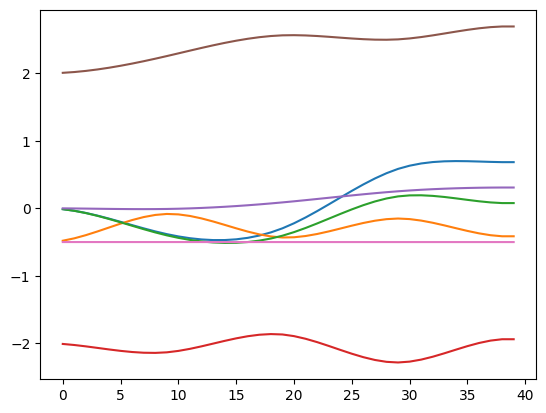

In [21]:
import matplotlib.pyplot as plt
plt.plot(q)
plt.show()

In [22]:
del C